# Compressing Vector Embeddings

To reduce space, accelerate search but maintain semantic meaning

1. **Vector Quantizaton** (make each number smaller) <br>
e.g. convert 64-bit floats to integer or bits 

2. **Dimensionality reduction** (use less numbers) <br>
e.g. truncate 3072 dimensions to 256 dimensions

## Vector Quantization

1. Scalar quantization (integer)
2. Binary quantization (single bit - 0 and 1)

In [1]:
import json

with open('embeddings/movies_text-embedding-3-small-1536.json') as f:
    movies = json.load(f)

movies['The Little Mermaid'][0:10]

[-0.0039056178648024797,
 0.019039113074541092,
 0.004666934721171856,
 0.003809679765254259,
 -0.012193450704216957,
 -0.02396601065993309,
 -0.028496775776147842,
 0.02036368101835251,
 -0.04020743817090988,
 -0.0006201174110174179]

### Scalar quantization
1. Find min max of the embeddings
2. Normalize the embeddings to [0,1]
3. Map the normalized embeddings to -128 to +127 (specified level)

In [2]:
def scalar_quantization(embeddings: list[list[float]], num_levels=256, min_level=-128, max_level=127):
    # Flatten the embeddings to find the global min and max
    flattened_embeddings = [
        number for embedding in embeddings for number in embedding
    ]
    min_val = min(flattened_embeddings)
    max_val = max(flattened_embeddings)
    
    # Normalize the embeddings to [0, 1]
    normalized_embeddings = [
        [(number - min_val) / (max_val - min_val) for number in embedding]
        for embedding in embeddings
    ]
    
    # Quantize the normalized values to the specified number of levels
    quantized_embeddings = [
        [int(round(number * (num_levels - 1)) * (max_level - min_level) / (num_levels - 1) + min_level)
        for number in embedding]
        for embedding in normalized_embeddings
    ]
    
    return quantized_embeddings

quantized_embeddings = scalar_quantization(list(movies.values()))
movies_1byte = {
    movie: quantized_embedding
    for movie, quantized_embedding in zip(movies.keys(), quantized_embeddings)
}

# Check the first 10 bytes of the quantized vector for 'Moana'
print(movies_1byte['The Little Mermaid'][0:10])

[29, 44, 35, 34, 24, 16, 13, 45, 6, 31]


In [3]:
import matplotlib.pyplot as plt


def render_vector(vector):
    """Visualize the values of the vector in a bar chart"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Set the face color of the axis (plot area) to light gray
    ax.set_facecolor('#f8e7ff')
    # Make sure the figure face color is transparent
    fig.patch.set_alpha(0.0)
    ax.bar(range(len(vector)), vector, color='purple')  # Set bar color to purple
    ax.set_xlabel('Dimension', fontweight='bold')  # Make x-axis label bold
    ax.set_ylabel('Value', fontweight='bold')  # Make y-axis label bold
    # Adjust the height of the graph
    fig.set_size_inches(fig.get_size_inches()[0], 3)
    plt.show()

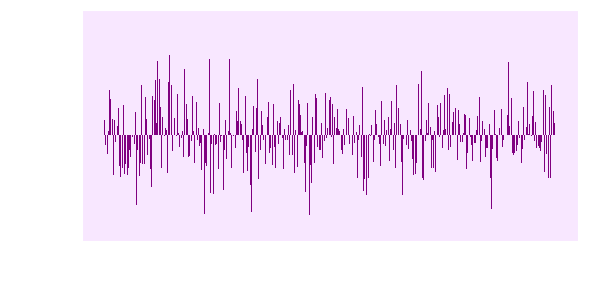

In [4]:
render_vector(movies['Moana'])

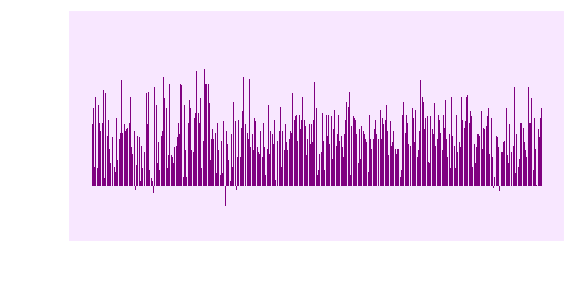

In [5]:
render_vector(movies_1byte['Moana'])

#### Comparison of results

Scalar quantization

In [6]:
# 10 most similar movies to Moana
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(movie, movies):
    movie_vec = movies[movie]
    similarities = {k: cosine_similarity([movie_vec], [v])[0][0] for k, v in movies.items()}
    closest = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(closest, columns=['movie', 'similarity'])
    return df

most_similar('Moana', movies_1byte)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.903532
2,The Little Mermaid,0.894227
3,Lilo & Stitch,0.893718
4,Big Hero 6,0.890959
5,Monsters University,0.890915
6,The Princess and the Frog,0.889009
7,Finding Dory,0.888350
8,Ice Princess,0.885539
9,Maleficent,0.885364


Original dimension

In [7]:

most_similar('Moana', movies)[:10]

,movie,similarity
0,Moana,1.000000
1,Mulan,0.546800
2,Lilo & Stitch,0.502114
3,The Little Mermaid,0.498209
4,Big Hero 6,0.491800
5,Monsters University,0.484857
6,The Princess and the Frog,0.471984
7,Finding Dory,0.471386
8,Maleficent,0.461029
9,Ice Princess,0.457817


### Binary quantization
1. Pick a mean/average of the dimensions
2. If value >=0, map to 1 <br>
<tab> value <=0, map to 0

In [8]:
def binary_quantization(embeddings):
    """Turn a float32 into a bit based off provided threshold"""
    
    # find mean of all the dimensions
    flattened_embeddings = [
        number for embedding in embeddings for number in embedding
    ]
    mean_val = sum(flattened_embeddings) / len(flattened_embeddings)
    
    # quantize the embeddings to 1 bit
    quantized_embeddings = [
        [1 if number > mean_val else 0 for number in embedding]
        for embedding in embeddings
    ]
    return quantized_embeddings

binary_quantized_embeddings = binary_quantization(list(movies.values()))
movies_1bit = {
    movie: quantized_embedding
    for movie, quantized_embedding in zip(movies.keys(), binary_quantized_embeddings)
}

# Check the first 10 bits of the quantized vector for 'Moana'
print(movies_1bit['Moana'][0:10])

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


In [9]:
render_vector(movies_1bit['Moana'], 'quant_1bit.png')

TypeError: render_vector() takes 1 positional argument but 2 were given

In [ ]:
most_similar('Moana', movies_1bit)[:10]

## Dimensionality Reduction


### MRL (Matryoshka Representation Learning) 
only supported by some vector embedding models

In [ ]:
import json

with open('embeddings/movies_text-embedding-3-small-1536.json') as f:
    movies_1536 = json.load(f)

with open('embeddings/movies_text-embedding-3-small-256.json') as f:
    movies_256t = json.load(f)

movie_title = "Moana"
print(len(movies_1536[movie_title]))
print(movies_1536[movie_title][0:5])

print(len(movies_256t[movie_title]))
print(movies_256t[movie_title][0:5])

In [ ]:
import matplotlib.pyplot as plt

def render_vector(vector, filename):
    """Visualize the values of the vector in a bar chart"""
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Set the face color of the axis (plot area) to light gray
    ax.set_facecolor('#ffe7f0')
    # Make sure the figure face color is transparent
    fig.patch.set_alpha(0.0)
    ax.bar(range(len(vector)), vector, color='#ff1c71')  # Set bar color to purple
    ax.set_xlabel('Dimension', fontweight='bold')  # Make x-axis label bold
    ax.set_ylabel('Value', fontweight='bold')  # Make y-axis label bold
    # Adjust the height of the graph
    fig.set_size_inches(fig.get_size_inches()[0], 3)
    plt.show()
    fig.savefig(filename, transparent=False, dpi=300, bbox_inches='tight')


render_vector(movies_1536['Moana'], "reduction_none.png")
render_vector(movies_256t['Moana'], "reduction_256.png")

#### Comparison


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(movie, movies):
    movie_vec = movies[movie]
    similarities = {k: cosine_similarity([movie_vec], [v])[0][0] for k, v in movies.items()}
    closest = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(closest, columns=['movie', 'similarity'])
    return df

most_similar('Moana', movies_1536)[:10]

In [ ]:

most_similar('Moana', movies_256t)[:10]

## Combining Vector Quantization & Dimensionality Reduction
For maximum vector compression

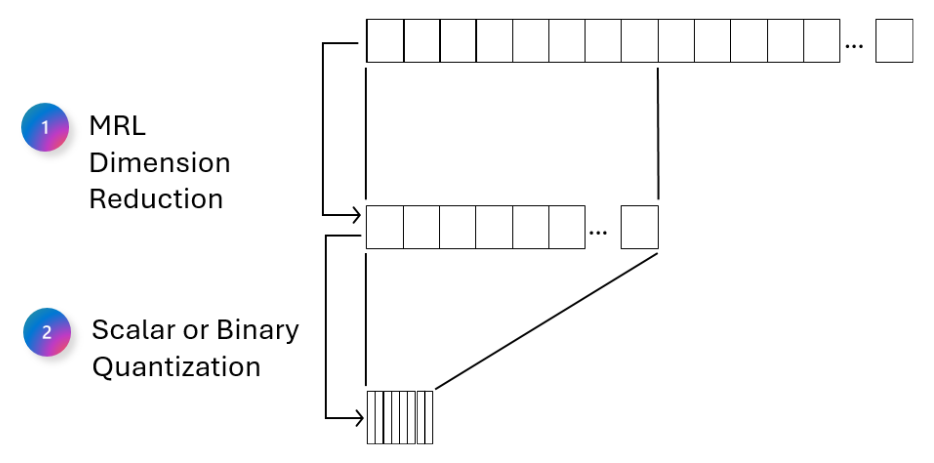

To maintain high accuracy:
1. Only compress vectors in index
2. Oversample when retrieving
3. Rescore using originals

https://www.youtube.com/watch?v=J3eDgwS8wpo